In [1]:
# load model
# https://github.com/ContextualAI/gritlm
from gritlm import GritLM
model = GritLM("GritLM/GritLM-7B", torch_dtype="auto", mode="embedding")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Created GritLM: torch.bfloat16 dtype, mean pool, embedding mode, bbcc attn


In [2]:
# embedding test
from scipy.spatial.distance import cosine
def get_similarity(embedding1, embedding2):
    return 1 - cosine(embedding1, embedding2)

texts = ["machine learning", "deep learning"]
results = model.encode(texts)
similarity = get_similarity(results[0], results[1])
print(results.shape, similarity)

(2, 4096) 0.9033003987849012


In [55]:
# load text
# files = ["text1_atari200.txt", "text2_shakespear", "text3_wikipedia.txt"]
files = ["text1_atari200.txt"]
text = ""
for file in files:
    with open(f'texts/{file}', "r") as f:
        text += f.read()
text = text.replace("\n", " ")
len(text), text[:100]

(28052,
 'Human-level Atari 200x faster Steven Kapturowski1 , Víctor Campos*1, Ray Jiang*1, Nemanja Rakićević1')

In [56]:
# split text into sentences
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
parts = word_tokenize(text)
len(parts), parts[:2]

[nltk_data] Downloading package punkt to /home/tobias/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(5522, ['Human-level', 'Atari'])

In [57]:
# create mini-sentences of N words
n = 15
sentences = []
for i in range(0, len(parts), n):
    sentence = " ".join(parts[i:i+n])
    sentences.append(sentence)
len(sentences), sentences[:2]

(369,
 ['Human-level Atari 200x faster Steven Kapturowski1 , Víctor Campos * 1 , Ray Jiang *',
  '1 , Nemanja Rakićević1 , Hado van Hasselt1 , Charles Blundell1 and Adrià Puigdomènech Badia1'])

In [58]:
# generate embedding for all sentences
import numpy as np
from tqdm import tqdm
from dataclasses import dataclass

@dataclass
class Sentence:
    text: str
    embedding: np.ndarray

results = []
for sentence in tqdm(sentences):
    embedding = model.encode(sentence)
    results.append(Sentence(sentence, embedding))

results[0].text, results[0].embedding.shape, results[0].embedding

100%|██████████| 369/369 [00:10<00:00, 35.62it/s]


('Human-level Atari 200x faster Steven Kapturowski1 , Víctor Campos * 1 , Ray Jiang *',
 (4096,),
 array([-0.01557161, -0.0254079 , -0.01817051, ...,  0.01457791,
         0.00328996,  0.03133292], dtype=float32))

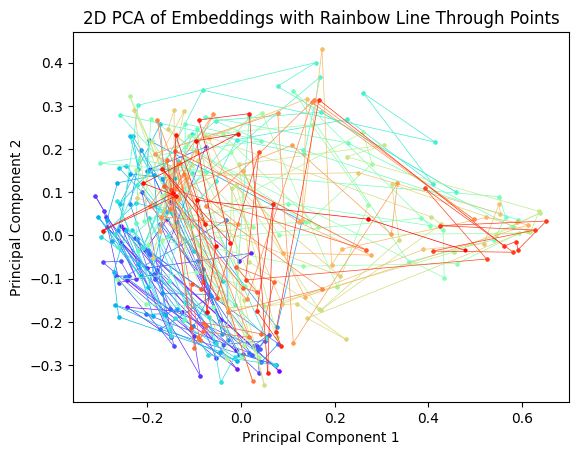

In [59]:
# Visualize
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Assuming embeddings are extracted as shown
embeddings = np.array([sentence.embedding for sentence in results])

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Generate colors
num_points = reduced_embeddings.shape[0]
colors = cm.rainbow(np.linspace(0, 1, num_points))

fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the points and the line through them in rainbow colors
for i in range(num_points - 1):
    ax.plot(reduced_embeddings[i:i+2, 0], reduced_embeddings[i:i+2, 1], color=colors[i], marker='o', markersize=2,linewidth=0.5)

plt.title('2D PCA of Embeddings with Rainbow Line Through Points')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [60]:
# calculate rolling embeddings
class RollingEmbedding:
    def __init__(self):
        self.children:list[Sentence] = []
        self.sentence = None
    
    def add_sentence(self, sentence:Sentence):
        self.children.append(sentence)
        self.update()
    
    def update(self):
        assert len(self.children) > 0
        if len(self.children) == 1:
            self.sentence = self.children[0]
            return

        text = " ".join([sentence.text for sentence in self.children])
        embedding = model.encode(text)
        self.sentence = Sentence(text, embedding)

    def remove_last(self):
        self.children.pop()
        self.update()

    def __repr__(self):
        return f"RollingEmbedding({len(self.children)}, {self.sentence.text}, {self.sentence.embedding})"


rolling_embeddings = []
working = RollingEmbedding()
for sentence in tqdm(results):
    working.add_sentence(sentence)
    if len(working.children) == 1:
        continue

    similarity = get_similarity(working.sentence.embedding, sentence.embedding)
    print(similarity)
    if similarity < 0.5:
        working.remove_last()
        rolling_embeddings.append(working.sentence)
        working = RollingEmbedding()

# add last working
if len(working.children) > 0:
    rolling_embeddings.append(working.sentence)

print()
print(len(rolling_embeddings))

for re in rolling_embeddings:
    print(f"- {re.embedding[:3]}... {re.text}")


  2%|▏         | 7/369 [00:01<00:53,  6.83it/s]

0.4568972587585449
0.6770126031048669
0.4527980089187622
0.8171213974284307
0.6235370488718734
0.6682327389717102


  4%|▍         | 14/369 [00:01<00:26, 13.50it/s]

0.44420117139816284
0.5735208988189697
0.6859162262628226
0.6350637078285217
0.44877982444883524


  6%|▌         | 21/369 [00:01<00:17, 19.69it/s]

0.6992569507497153
0.5522147746214147
0.7230352163314819
0.5493561625480652
0.5439458165201068
0.6779555082321167
0.4712625111654447


  8%|▊         | 29/369 [00:02<00:13, 26.09it/s]

0.6185305118560791
0.6830753872945686
0.7457679732372756
0.6763271689414978
0.6236775293158023
0.589706217629089
0.44367977641104406


 10%|█         | 37/369 [00:02<00:10, 30.37it/s]

0.7556201219558716
0.500055193901062
0.7091760039329529
0.6951204538345337
0.6327151279023224
0.5989061354938837
0.47691026467619835


 12%|█▏        | 45/369 [00:02<00:10, 32.12it/s]

0.5095172080253725
0.5960897207260132
0.7209850549697876
0.6612345374366377
0.653703370911085
0.42307851520882855


 14%|█▍        | 53/369 [00:02<00:09, 32.30it/s]

0.8339162070851138
0.809779942035675
0.8010776757551639
0.7288526296615601
0.6346293309551887
0.6080382232688809
0.7115439348492674


 17%|█▋        | 61/369 [00:02<00:09, 31.50it/s]

0.45821574828437317
0.6472195982933044
0.7128761239574042
0.5159049034118652
0.5203568339347839
0.3820565868649839


 19%|█▉        | 70/369 [00:03<00:07, 37.64it/s]

0.6725890446587048
0.6788169347887321
0.42454594373703003
0.7708077567334334
0.6256534307416208
0.5511088906396797
0.6464806584406303


 20%|██        | 74/369 [00:03<00:08, 35.87it/s]

0.6498939186271392
0.611737072467804
0.5877472337409032
0.5289186712132717
0.5802315819401502
0.6077043647942336
0.4500980704964366


 22%|██▏       | 82/369 [00:03<00:08, 34.75it/s]

0.7906780963731961
0.6287482976913452
0.5251855567208273
0.5673699717146151
0.6616562806572759
0.6906404495239258
0.47346475562243273


 24%|██▍       | 90/369 [00:03<00:08, 34.44it/s]

0.7716985208808508
0.6910204887390137
0.6304272789017735
0.6369546055793762
0.640978217124939
0.6195279359817505
0.6902376023005727


 27%|██▋       | 99/369 [00:04<00:07, 35.14it/s]

0.48240785143445786
0.5985014081894523
0.617784463299248
0.6604159075145697
0.710970401763916
0.6905580184362575
0.5792728913263754


 29%|██▉       | 107/369 [00:04<00:08, 31.57it/s]

0.5688819371321167
0.5637052227170835
0.5979828238487244
0.5789010697275722
0.6719308095019585
0.5859629686463766


 30%|███       | 111/369 [00:04<00:08, 28.93it/s]

0.6469085391650888
0.46863535046577454
0.7825902104377747
0.7285193098365313
0.6229294128098911
0.5715319088557934


 32%|███▏      | 119/369 [00:04<00:08, 28.19it/s]

0.645201563835144
0.6915164177706005
0.5115305490213969
0.5662596821784973
0.4246648676593564
0.8847542932483148


 35%|███▍      | 128/369 [00:05<00:07, 33.13it/s]

0.8301553377555415
0.5040902350029579
0.6269162074873582
0.493181049823761
0.6935529708862305
0.6366763114929199
0.7360394659077673


 36%|███▌      | 132/369 [00:05<00:07, 33.85it/s]

0.6436061475511713
0.7451223134994507
0.6105044251981045
0.5594887900200128
0.6308110952377319
0.5195516812400554
0.4682017006633672


 38%|███▊      | 141/369 [00:05<00:06, 34.45it/s]

0.921951174736023
0.6369530774978961
0.6402778839899382
0.658731659016957
0.5096930721127774
0.6040800157856979
0.5300929230396206


 39%|███▉      | 145/369 [00:05<00:06, 32.22it/s]

0.6429150104522705
0.6949308282219425
0.5602983236312866
0.5844425311352341
0.416016961098729


 42%|████▏     | 154/369 [00:05<00:07, 28.92it/s]

0.8478289751904607
0.7615990865707128
0.7957098003366443
0.6734082698822021
0.6453147530555725
0.6676986813545227
0.6026285649912705


 44%|████▍     | 163/369 [00:06<00:06, 31.77it/s]

0.4436590339934259
0.8579311286169978
0.6222175134550054
0.5429426431655884
0.5293020325483112
0.591135894723887


 46%|████▋     | 171/369 [00:06<00:06, 31.48it/s]

0.6321143884727005
0.557548999786377
0.5456900000572205
0.4851165106962041
0.8019786359059011
0.8032210351956522


 47%|████▋     | 175/369 [00:06<00:06, 30.38it/s]

0.6974155902862549
0.6966297626495361
0.6903310439286597
0.5005204230702052
0.48203502434805445


 50%|████▉     | 183/369 [00:06<00:06, 29.80it/s]

0.7485872953288149
0.8072734360261834
0.6185513919160187
0.7187154293060303
0.7624351978302002
0.5347208380699158
0.5782334804534912


 51%|█████     | 187/369 [00:07<00:06, 27.55it/s]

0.5002576112747192
0.5590181087862328
0.6277682781219482
0.48826833034361417


 53%|█████▎    | 194/369 [00:07<00:06, 29.11it/s]

0.6759997606277466
0.7773959306006569
0.332444429397583
0.8310519255461664
0.787451816353095
0.5647674202919006
0.38482471614031355


 55%|█████▌    | 203/369 [00:07<00:04, 34.64it/s]

0.6427494287490845
0.43256980180740356
0.7540876865386963
0.8422564268112183
0.814210511947937
0.6449088454246521
0.5343257743923971


 57%|█████▋    | 212/369 [00:07<00:04, 35.35it/s]

0.4976740777492523
0.9108778781222049
0.5352767428920722
0.7306069296236689
0.5986029505729675
0.6150952944216319


 60%|█████▉    | 220/369 [00:07<00:04, 34.88it/s]

0.8338791926051208
0.49386510252952576
0.8350769877433777
0.7552227523790163
0.43225453188311014
0.7122772589060428


 62%|██████▏   | 228/369 [00:08<00:03, 36.84it/s]

0.4802006196856138
0.5613343715667725
0.5431069356607997
0.6239291801410436
0.7351500611051939
0.5084149544486385
0.37792886758698874


 64%|██████▍   | 236/369 [00:08<00:04, 31.68it/s]

0.8905286989088719
0.8972661640146719
0.8011655807495117
0.7867803808087227
0.7525878997199489
0.5636489895268394


 65%|██████▌   | 240/369 [00:08<00:04, 28.92it/s]

0.61680731873556
0.4050958043451105
0.6699182587910748
0.7138952016830444
0.3940185308456421


 67%|██████▋   | 249/369 [00:08<00:03, 33.72it/s]

0.5979588867450435
0.49758455128485934
0.897575518272122
0.6341309983574199
0.6226218078467033
0.5246102497213939
0.5569510459899902


 70%|██████▉   | 257/369 [00:09<00:03, 34.14it/s]

0.35978440286014135
0.8387269031622087
0.6150510081679241
0.6372213796113322
0.6333600878715515
0.5443167090415955


 72%|███████▏  | 265/369 [00:09<00:03, 32.04it/s]

0.42461414410514087
0.8341749559096983
0.6387950968383285
0.7297481298446655
0.5456664562225342
0.47756773233413696


 73%|███████▎  | 269/369 [00:09<00:03, 31.81it/s]

0.7672448893043479
0.7603500795781761
0.4633607268333435
0.7797221541404724
0.7044582190786743
0.7237342000007629


 75%|███████▌  | 278/369 [00:09<00:02, 32.24it/s]

0.5262828343763523
0.6093174684861383
0.5542018413543701
0.4530674545128679
0.735806731677863
0.8479658365249634


 78%|███████▊  | 286/369 [00:10<00:02, 32.00it/s]

0.5698850324715686
0.5756371364377233
0.6709720288548483
0.5750150680541992
0.6223591566085815
0.6208858860067072


 79%|███████▊  | 290/369 [00:10<00:02, 29.56it/s]

0.573541956351458
0.6091270083709365
0.6161428551503636
0.5556611153877457
0.41517871618270874


 81%|████████  | 298/369 [00:10<00:02, 30.09it/s]

0.6756410800111619
0.8297513025850849
0.6997987449049214
0.5949257612228394
0.7032564878463745
0.5617670343199967
0.572438325140577


 83%|████████▎ | 306/369 [00:10<00:02, 31.02it/s]

0.49564093351364136
0.6979443014893365
0.7656892538070679
0.6894430929090448
0.4661475121974945


 84%|████████▍ | 310/369 [00:10<00:01, 32.72it/s]

0.7957850098609924
0.708994886547175
0.6724197864532471
0.5261102036303412
0.34122646801314005
0.6699182587910748
0.4812757207103737


 86%|████████▋ | 319/369 [00:11<00:01, 35.95it/s]

0.8335291842502857
0.8034685967285292
0.5362844467163086
0.6211825383414362
0.5261645630696165
0.45206892490386963


 89%|████████▊ | 327/369 [00:11<00:01, 32.68it/s]

0.8344391039668271
0.6894243379912706
0.6577798520195408
0.7640420198440552
0.49155615244973183
0.6499926269063249
0.5222177194227157


 91%|█████████ | 336/369 [00:11<00:00, 34.79it/s]

0.6534843857903067
0.560489919156438
0.6692815425349687
0.5114758471974018
0.47691050309476324
0.5973783491479377


 92%|█████████▏| 340/369 [00:11<00:00, 33.70it/s]

0.7589597105979919
0.5765415682469874
0.6591356992721558
0.6300510984628749
0.7302627563476562
0.6579185724258423


 93%|█████████▎| 344/369 [00:11<00:00, 29.03it/s]

0.6053462208910653
0.5931150670716216
0.6043249548770476
0.5379237487407068


 95%|█████████▌| 352/369 [00:12<00:00, 25.27it/s]

0.4645478746564471
0.7659235000610352
0.6466633063551785
0.4246802076887968
0.843374559678165


 98%|█████████▊| 361/369 [00:12<00:00, 30.07it/s]

0.5438382949732727
0.6147898802035987
0.5333448052406311
0.5084649920463562
0.607338643511454
0.6940920535271148
0.5098035627720625


 99%|█████████▉| 365/369 [00:12<00:00, 26.07it/s]

0.6069888057407383
0.6483811736106873
0.5450939698545331
0.4277857371504826
0.8640988726645376


100%|██████████| 369/369 [00:12<00:00, 28.86it/s]

0.6785827875137329
0.4140358094583695

51
- [-0.01557161 -0.0254079  -0.01817051]... Human-level Atari 200x faster Steven Kapturowski1 , Víctor Campos * 1 , Ray Jiang *
- [-0.02603287 -0.00751503 -0.04296087]... 1DeepMind , * Equal contribution The task of building general agents that perform well over a wide range of tasks has been an important goal in reinforcement learning since its
- [ 0.0004417  -0.02145078 -0.02547888]... , with performance frequently measured by observing scores over the wide range of environments contained in the Atari 57 benchmark . Agent57 was the first agent to surpass the human benchmark on all 57 games , but this came at the cost of poor data-efficiency , requiring nearly 80 billion frames of experience to achieve . Taking Agent57 as a
- [-0.00948606  0.00431292 -0.01314658]... of experience needed to outperform the human baseline . We investigate a range of instabilities and bottlenecks we encountered while reducing the data regime , and propose effecti